In [1]:
import os
import time
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from zipfile import ZipFile
import skimage.io
from PIL import Image
import seaborn as sns
from sklearn.manifold import TSNE

from mnist_generator import get_mnist_loaders
from mnistm_generator import get_mnistm_loaders
from DANN import *
from DA import DenoisingAutoencoder
from test import *
from train import *
from visualize import *
from util import *

# make sure using CPU

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
device

device(type='cuda', index=0)

# mnist dataset

In [4]:
mnist_train_loader,mnist_eval_loader, mnist_test_loader = get_mnist_loaders(batch_size=64)

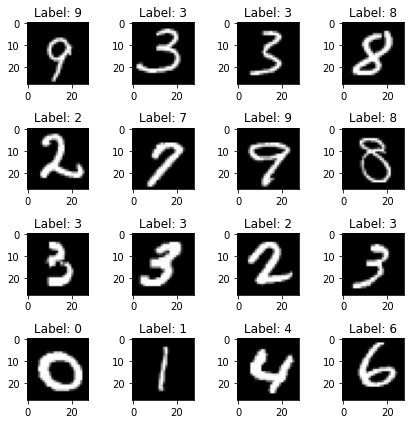

In [5]:

visualize_mnist(mnist_train_loader,4)

# mnistm dataset

In [6]:

mnistm_train_loader, mnistm_eval_loader,mnistm_test_loader = get_mnistm_loaders(batch_size=64)

C:\Users\15197\Desktop\cs9542_final_project\mnistm_generator.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  background = np.random.choice(backgrounds)


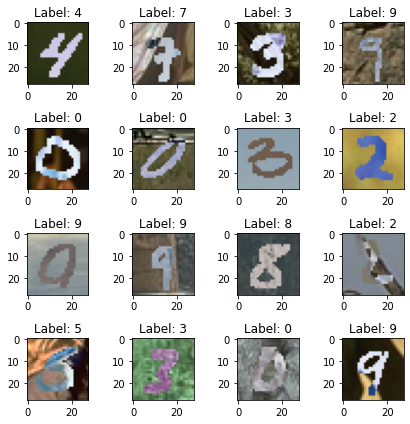

In [7]:
visualize_mnistm(mnistm_train_loader,4)

# visualization of representation

In [ ]:
features, labels = generate_domain_datas(mnist_train_loader, mnistm_train_loader)


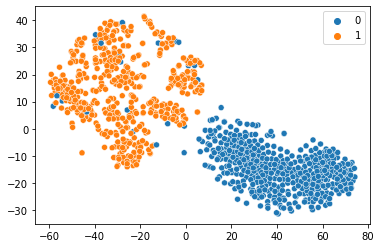

In [117]:

visualize_domain(features, labels, size=1000)

# source only

In [8]:
source_accs, extractor, classifier = DANNTrain_source_only(mnist_train_loader, mnist_eval_loader,epochs=50)

1/50: source_acc: 0.9881333333333333
2/50: source_acc: 0.9927666666666667
3/50: source_acc: 0.9944333333333333
4/50: source_acc: 0.9958166666666667
5/50: source_acc: 0.9965166666666667
6/50: source_acc: 0.99735
7/50: source_acc: 0.9978
8/50: source_acc: 0.9979833333333333
9/50: source_acc: 0.99815
10/50: source_acc: 0.9983166666666666
11/50: source_acc: 0.9985333333333334
12/50: source_acc: 0.99865
13/50: source_acc: 0.9987333333333334
14/50: source_acc: 0.9987666666666667
15/50: source_acc: 0.9988166666666667
16/50: source_acc: 0.99895
17/50: source_acc: 0.9989833333333333
18/50: source_acc: 0.9990333333333333
19/50: source_acc: 0.9990666666666667
20/50: source_acc: 0.9990666666666667
21/50: source_acc: 0.9990666666666667
22/50: source_acc: 0.9990666666666667
23/50: source_acc: 0.9991
24/50: source_acc: 0.9991
25/50: source_acc: 0.9991166666666667
26/50: source_acc: 0.99915
27/50: source_acc: 0.9991666666666666
28/50: source_acc: 0.9991833333333333
29/50: source_acc: 0.9992
30/50: sou

KeyboardInterrupt: 

# target only

In [8]:
target_accs, extractor, classifier = DANNTrain_target_only(mnistm_train_loader, mnistm_eval_loader, epochs=30)

1/30: target_acc: 0.9354166666666667
2/30: target_acc: 0.9519
3/30: target_acc: 0.95895
4/30: target_acc: 0.96395
5/30: target_acc: 0.9663333333333334
6/30: target_acc: 0.96785
7/30: target_acc: 0.9716666666666667
8/30: target_acc: 0.9728
9/30: target_acc: 0.9737333333333333
10/30: target_acc: 0.9756166666666667
11/30: target_acc: 0.9753166666666667
12/30: target_acc: 0.9767833333333333
13/30: target_acc: 0.9766666666666667
14/30: target_acc: 0.9779833333333333
15/30: target_acc: 0.9788833333333333
16/30: target_acc: 0.9795166666666667
17/30: target_acc: 0.98
18/30: target_acc: 0.9802166666666666
19/30: target_acc: 0.9792833333333333
20/30: target_acc: 0.98145
21/30: target_acc: 0.9816
22/30: target_acc: 0.9815666666666667
23/30: target_acc: 0.9817166666666667
24/30: target_acc: 0.9825666666666667
25/30: target_acc: 0.982
26/30: target_acc: 0.9823666666666667
27/30: target_acc: 0.9830166666666666
28/30: target_acc: 0.98365
29/30: target_acc: 0.9829666666666667
30/30: target_acc: 0.9833

# build DANN model

In [8]:
source_accs, target_accs, domain_accs, extractor, classifier, discriminator = DANNTrain(
      mnist_train_loader,
      mnistm_train_loader,
      mnist_eval_loader,
      mnistm_eval_loader,
      epochs=10)

1/10: source_acc: 0.9135833333333333,target_acc: 0.44276666666666664, domain_acc: 0.6974083333333333
2/10: source_acc: 0.9698166666666667,target_acc: 0.50015, domain_acc: 0.6363583333333334
3/10: source_acc: 0.97475,target_acc: 0.4739, domain_acc: 0.567725
4/10: source_acc: 0.9768166666666667,target_acc: 0.47141666666666665, domain_acc: 0.43051666666666666
5/10: source_acc: 0.97925,target_acc: 0.4222, domain_acc: 0.27474166666666666
6/10: source_acc: 0.9803166666666666,target_acc: 0.44005, domain_acc: 0.6370833333333333


KeyboardInterrupt: 

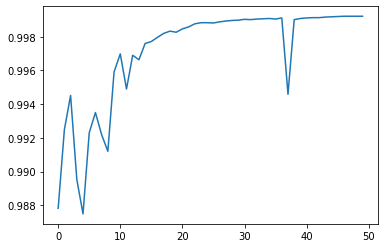

In [9]:
plt.plot(source_accs)

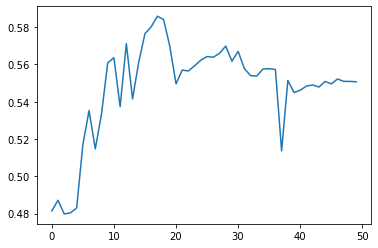

In [10]:
plt.plot(target_accs)

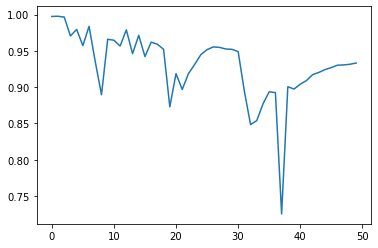

In [11]:
plt.plot(domain_accs)

# test on test set

In [12]:
DANNAccuracy(extractor, classifier, discriminator, mnist_test_loader, mnistm_test_loader)

(0.9927, 0.5496, 0.93405)

# visualize the features after extractor

In [13]:
from util import generate_domain_datas_from_extractor
features, labels = generate_domain_datas_from_extractor(extractor, mnist_train_loader,mnistm_train_loader)

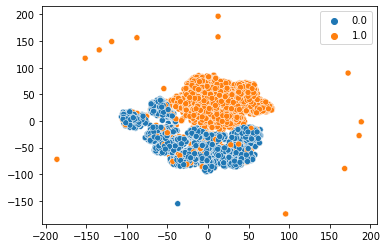

In [15]:
visualize_domain_tSNE(features, labels,size=10000)

# Denoising Autoencoders

In [8]:
loss_arr, autoencoder = DATrain(mnist_train_loader, mnistm_train_loader, mnist_eval_loader, mnistm_eval_loader,1000,100)

1/100: avg_loss:0.11483067274093628
2/100: avg_loss:0.09181162714958191
3/100: avg_loss:0.07582124322652817
4/100: avg_loss:0.06512131541967392
5/100: avg_loss:0.05722137168049812
6/100: avg_loss:0.05117691308259964
7/100: avg_loss:0.046461429446935654
8/100: avg_loss:0.042651329189538956
9/100: avg_loss:0.03974293917417526
10/100: avg_loss:0.03742653876543045
11/100: avg_loss:0.03554382547736168
12/100: avg_loss:0.0339069627225399
13/100: avg_loss:0.03245691955089569
14/100: avg_loss:0.03132209926843643
15/100: avg_loss:0.03028463013470173
16/100: avg_loss:0.02942045032978058
17/100: avg_loss:0.028599031269550323
18/100: avg_loss:0.027897696942090988
19/100: avg_loss:0.02726096659898758
20/100: avg_loss:0.02674141526222229
21/100: avg_loss:0.026187391951680183
22/100: avg_loss:0.025733469054102898
23/100: avg_loss:0.025307737290859222
24/100: avg_loss:0.024853214621543884
25/100: avg_loss:0.024516357108950615
26/100: avg_loss:0.024068474769592285
27/100: avg_loss:0.023727785795927048


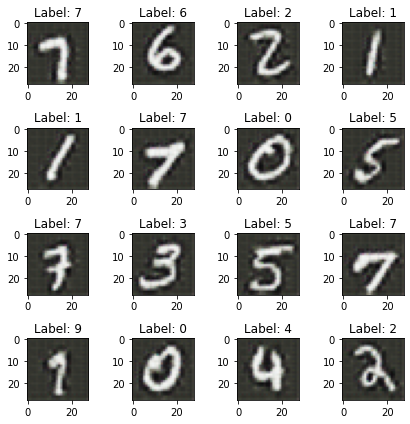

In [9]:
visualize_mnist_from_DA(autoencoder,mnist_train_loader,4)

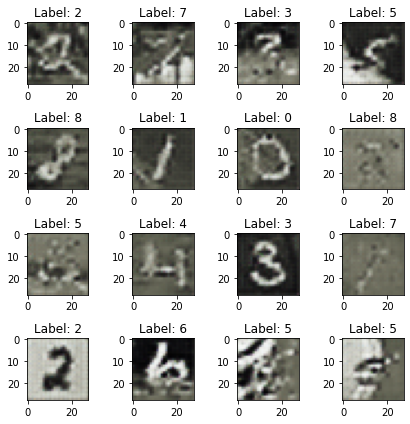

In [10]:
visualize_mnistm_from_DA(autoencoder,mnistm_train_loader,4)

In [12]:
save_DA(autoencoder,"./models/da_v1_100.pt")

In [8]:
autoencoder = DenoisingAutoencoder(100)
autoencoder = load_DA("./models/da_v1_100.pt")

# DANN with autoencoder

In [10]:
source_accs, target_accs, domain_accs, extractor, classifier, discriminator=DANNTrain_with_Autoencoder(autoencoder, 
                                                                                                       mnist_train_loader, 
                                                                                                       mnistm_train_loader, 
                                                                                                       mnist_eval_loader, 
                                                                                                       mnistm_eval_loader, 
                                                                                                       30)

1/30: source_acc: 0.47713333333333335,target_acc: 0.20491666666666666, domain_acc: 0.89025
2/30: source_acc: 0.54765,target_acc: 0.2610166666666667, domain_acc: 0.7048416666666667
3/30: source_acc: 0.6014333333333334,target_acc: 0.33368333333333333, domain_acc: 0.6489416666666666
4/30: source_acc: 0.63075,target_acc: 0.34486666666666665, domain_acc: 0.5856
5/30: source_acc: 0.6653333333333333,target_acc: 0.3542166666666667, domain_acc: 0.5142583333333334
6/30: source_acc: 0.6864333333333333,target_acc: 0.36441666666666667, domain_acc: 0.5
7/30: source_acc: 0.7028166666666666,target_acc: 0.3666333333333333, domain_acc: 0.5
8/30: source_acc: 0.7371666666666666,target_acc: 0.3685833333333333, domain_acc: 0.5
9/30: source_acc: 0.7672333333333333,target_acc: 0.3848666666666667, domain_acc: 0.5
10/30: source_acc: 0.7801166666666667,target_acc: 0.3935666666666667, domain_acc: 0.5
11/30: source_acc: 0.7837833333333334,target_acc: 0.40113333333333334, domain_acc: 0.5
12/30: source_acc: 0.786516

In [18]:
save_DANN_with_DA(extractor, classifier,discriminator)

In [11]:
DANNAccuracy_with_DA(autoencoder,extractor, classifier, discriminator, mnist_test_loader, mnistm_test_loader)

(0.9629, 0.4451, 0.5)

In [13]:
features, labels = generate_domain_datas_from_extractor_with_DA(autoencoder,extractor, mnist_train_loader,mnistm_train_loader)

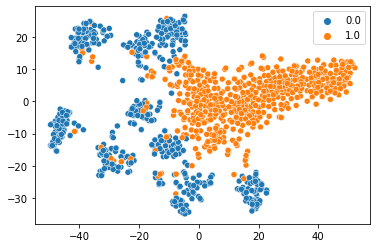

In [15]:
visualize_domain_tSNE(features, labels,size=1000)

# Proxy A-distance

In [71]:
class ReverseLayerF(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)
    
    @staticmethod
    def backward(ctx, grad_output):
        output = ctx.alpha * grad_output.neg()
        return output, None
    
class DANN(nn.Module):
    def __init__(self):
        super(DANN,self).__init__()
        self.extractor = nn.Sequential(
            # 3 x 28 x 28
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # 64 x 24 x 24
            nn.MaxPool2d(kernel_size=2),
            # 64 x 12 x 12
            nn.Conv2d(in_channels=32, out_channels=64,kernel_size=5),
            # 50 x 8 x 8
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(),
            nn.MaxPool2d(kernel_size=2))
            # 50 x 4 x 4
        self.classifier = nn.Sequential(
            nn.Linear(in_features = 64*4*4, out_features = 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(in_features=100, out_features=100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(in_features = 100, out_features=10),
            nn.LogSoftmax(dim=1))
        self.discriminator = nn.Sequential(
            nn.Linear(in_features=64*4*4, out_features=100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=2),
            nn.LogSoftmax(dim=1))
        
        
    def forward(self,x,alpha):
        x = x.expand(x.data.shape[0],3,28,28)
        x = self.extractor(x)
        x = x.view(-1,64*4*4)
        rev_x = ReverseLayerF.apply(x,alpha)
        labels = self.classifier(x)
        domains = self.discriminator(rev_x)
        return labels, domains


In [72]:
def DANNTrain(mnist_train, mnistm_train, mnist_eval, mnistm_eval, epochs):
    dann = DANN().to(device)

    criterion= nn.CrossEntropyLoss().to(device)
    optimizer = optim.SGD(
        list(dann.parameters()),lr=0.01)
    domain_accs =[]
    source_accs = []
    target_accs = []
    total_steps = epochs* len(mnistm_train)
    for epoch in range(epochs):
        start_steps = epoch * len(mnist_train)
        
        for batch_idx, (source, target) in enumerate(zip(mnist_train, mnistm_train)):
            source_image, source_label = source
            target_image, target_label = target

            p = float(batch_idx + start_steps)/ total_steps
            alpha = 2. / (1.+np.exp(-10*p))-1 

            # the source is 1 * 28 * 28, we have to preprocess it
            #source_image = torch.cat((source_image, source_image, source_image),1)
            source_image, source_label = source_image.to(device), source_label.to(device)
            target_image, target_label = target_image.to(device), target_label.to(device)
            #total_image = torch.cat((source_image, target_image), 0)
            #domain_label = torch.cat((torch.zeros(source_label.size()[0]).type(torch.LongTensor),
#                                    torch.ones(target_label.size()[0]).type(torch.LongTensor)),0).to(device)

            # update learning rate
            for param_group in optimizer.param_groups:
                param_group['lr'] = 0.01/(1.+10*p)**0.75

            # clear the grad
            optimizer.zero_grad()
            
            source_yp_labels, source_yp_domains = dann(source_image,alpha)
            target_yp_labels, target_yp_domains = dann(target_image,alpha)

            
            source_labels_loss = criterion(source_yp_labels, source_label)
            source_domain_loss = criterion(source_yp_domains, torch.zeros(source_label.size()[0]).type(torch.LongTensor).to(device))
            target_domain_loss = criterion(target_yp_domains, torch.ones(target_label.size()[0]).type(torch.LongTensor).to(device))
            
            total_loss = source_labels_loss + source_domain_loss + target_domain_loss
            total_loss.backward()
            optimizer.step()

        with torch.no_grad():
            source_acc, target_acc, domain_acc = DANNAccuracy(dann, mnist_eval, mnistm_eval)
            domain_accs.append(domain_acc)
            source_accs.append(source_acc)
            target_accs.append(target_acc)
            print(f'{epoch+1}/{epochs}: source_acc: {source_acc},target_acc: {target_acc}, domain_acc: {domain_acc}')
    return source_accs, target_accs, domain_accs, dann

In [73]:
def DANNAccuracy(dann, mnist_gen, mnistm_gen):
    s_cor = 0
    t_cor = 0
    domain_cor = 0
    for batch_idx, (source, target) in enumerate(zip(mnist_gen, mnistm_gen)):
        p = float(batch_idx)/len(mnist_gen)
        alpha = 2. / (1.+np.exp(-10*p))-1 
        source_image, source_label = source
        target_image, target_label = target
        
        source_image, source_label = source_image.to(device), source_label.to(device)
        target_image, target_label = target_image.to(device), target_label.to(device)
        
                
        source_yp_labels, source_yp_domains = dann(source_image,alpha)
        target_yp_labels, target_yp_domains = dann(target_image, alpha)
        
        source_yp_labels = source_yp_labels.data.max(1,keepdim=True)[1]
        s_cor += source_yp_labels.eq(source_label.data.view_as(source_yp_labels)).cpu().sum().item()
        
        target_yp_labels = target_yp_labels.data.max(1,keepdim=True)[1]
        t_cor += target_yp_labels.eq(target_label.data.view_as(target_yp_labels)).cpu().sum().item()
        
        source_y_domains = torch.zeros(source_label.size()[0]).type(torch.LongTensor).to(device)
        target_y_domains =  torch.ones(target_label.size()[0]).type(torch.LongTensor).to(device)
        
        source_yp_domains = source_yp_domains.data.max(1,keepdim=True)[1]
        domain_cor += source_yp_domains.eq(source_y_domains.data.view_as(source_yp_domains)).cpu().sum().item()
        target_yp_domains = target_yp_domains.data.max(1,keepdim=True)[1]
        domain_cor += target_yp_domains.eq(target_y_domains.data.view_as(target_yp_domains)).cpu().sum().item()

    domain_acc = domain_cor.item()/(len(mnist_gen.dataset)+len(mnistm_gen.dataset))
    s_acc = s_cor.item()/len(mnist_gen.dataset)
    t_acc = t_cor.item()/len(mnistm_gen.dataset)
    return s_acc, t_acc, domain_acc

In [75]:
source_accs, target_accs, domain_accs, dann = DANNTrain(
      mnist_train_loader,
      mnistm_train_loader,
      mnist_eval_loader,
      mnistm_eval_loader,
      epochs=100)

1/100: source_acc: 0.9267666666666666,target_acc: 0.4595166666666667, domain_acc: 0.61865
2/100: source_acc: 0.9528,target_acc: 0.5004666666666666, domain_acc: 0.686175
3/100: source_acc: 0.96165,target_acc: 0.5276666666666666, domain_acc: 0.7265916666666666
4/100: source_acc: 0.965,target_acc: 0.5336333333333333, domain_acc: 0.790725
5/100: source_acc: 0.9661666666666666,target_acc: 0.5642166666666667, domain_acc: 0.7631666666666667
6/100: source_acc: 0.9661,target_acc: 0.6090666666666666, domain_acc: 0.759675
7/100: source_acc: 0.9668833333333333,target_acc: 0.62165, domain_acc: 0.7467416666666666
8/100: source_acc: 0.9665,target_acc: 0.6558, domain_acc: 0.7504666666666666
9/100: source_acc: 0.9661166666666666,target_acc: 0.6883, domain_acc: 0.7450666666666667
10/100: source_acc: 0.9641833333333333,target_acc: 0.7246833333333333, domain_acc: 0.7216916666666666
11/100: source_acc: 0.9656666666666667,target_acc: 0.73915, domain_acc: 0.7236416666666666
12/100: source_acc: 0.961233333333

92/100: source_acc: 0.9741666666666666,target_acc: 0.9025833333333333, domain_acc: 0.58355
93/100: source_acc: 0.9721,target_acc: 0.9011, domain_acc: 0.5836916666666667
94/100: source_acc: 0.9752333333333333,target_acc: 0.9027666666666667, domain_acc: 0.5944
95/100: source_acc: 0.9734333333333334,target_acc: 0.90315, domain_acc: 0.5828916666666667
96/100: source_acc: 0.9751666666666666,target_acc: 0.9036833333333333, domain_acc: 0.5863083333333333
97/100: source_acc: 0.97255,target_acc: 0.90115, domain_acc: 0.5776
98/100: source_acc: 0.97255,target_acc: 0.9037333333333334, domain_acc: 0.579925
99/100: source_acc: 0.97215,target_acc: 0.9017166666666667, domain_acc: 0.5745166666666667
100/100: source_acc: 0.9742333333333333,target_acc: 0.9007333333333334, domain_acc: 0.5778416666666667


In [76]:
save_model(dann,"./models/dann_v1.pt")

In [83]:
def generate_domain_datas_from_dann(dann, mnist_gen,mnistm_gen):
    with torch.no_grad():
        total_x = torch.tensor([])
        total_y = torch.tensor([])
        for batch_idx, (source, target) in enumerate(zip(mnist_gen, mnistm_gen)):
            source_image, source_label = source
            target_image, target_label = target

            # the source is 1 * 28 * 28, we have to preprocess it
            #source_image = torch.cat((source_image, source_image, source_image),1)

            domain_label = torch.cat((torch.zeros(source_label.size()[0]).type(torch.LongTensor),
                                        torch.ones(target_label.size()[0]).type(torch.LongTensor)),0)
            source = source_image.expand(source_image.data.shape[0],3,28,28)
            source = dann.extractor(source.to(device))
            source = source.view(-1,64*4*4).cpu()
            target = target_image.expand(target_image.data.shape[0],3,28,28)
            target = dann.extractor(target.to(device))
            target = target.view(-1,64*4*4).cpu()
            temp = torch.cat((source,target),0)
            total_x = torch.cat((total_x,temp),0)
            total_y = torch.cat((total_y,domain_label),0)
    return total_x, total_y

In [84]:
features, labels = generate_domain_datas_from_dann(dann, mnist_train_loader,mnistm_train_loader)

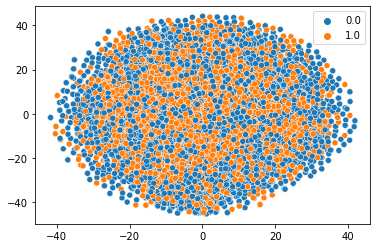

In [86]:
visualize_domain_tSNE(features, labels,size=10000)

In [88]:
s_acc, t_acc, domain_acc = DANNAccuracy(dann, mnist_test_loader,mnistm_test_loader)

In [89]:
s_acc

0.97

In [90]:
t_acc

0.9001